In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns 
from datetime import timedelta

## Initial Analysis

In [9]:
pred_df = pd.read_csv('../predictions/predicted_cases_v2.csv')
pred_df.Day = pd.to_datetime(pred_df.Day)

In [5]:
start_date = pd.to_datetime("2020-12-16")
default_maxT = pd.to_datetime("2021-03-15")
end_date = pd.to_datetime("2021-01-13")

boston_cases = pd.read_excel("processed/boston_cases.xlsx")
boston_cases.Timestamp = pd.to_datetime(boston_cases.Timestamp, errors='coerce')
boston_cases = boston_cases[(boston_cases.Timestamp >= start_date) & (boston_cases.Timestamp <= end_date)]

cambridge_cases = pd.read_csv("processed/COVID-19_Case_Count_by_Date.csv")
cambridge_cases.Date = pd.to_datetime(cambridge_cases.Date)
cambridge_cases = cambridge_cases.query("Date >= @start_date and Date <= @end_date")

truth_df = pd.DataFrame({
    'date': np.array(cambridge_cases.Date),
    'case_cnt': np.array(cambridge_cases['Cumulative Confirmed Cases']) + np.array(boston_cases['Cases: Total Positive'])
})

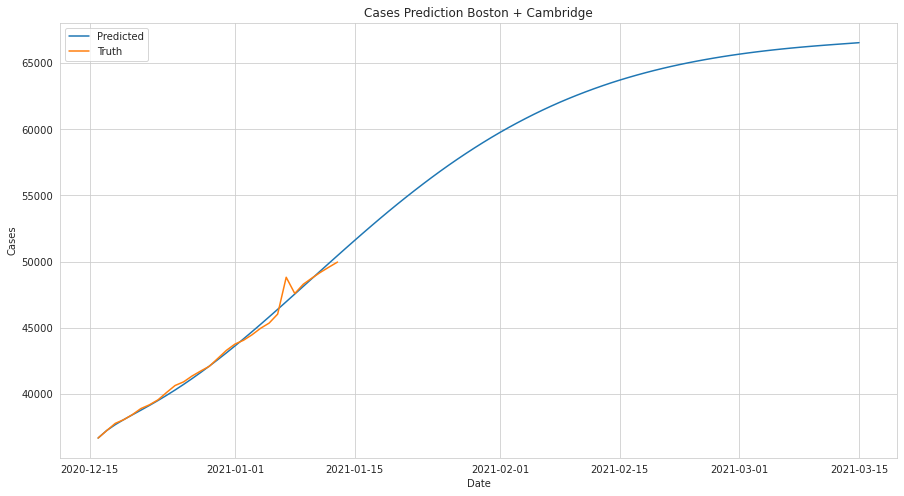

In [10]:
with sns.axes_style("whitegrid"):
    plt.figure(figsize=(15,8))
    sns.lineplot(data=pred_df, x='Day', y='Total Cases')
    sns.lineplot(data=truth_df, x='date', y='case_cnt')
    plt.ylabel('Cases')
    plt.xlabel('Date')
    plt.title('Cases Prediction Boston + Cambridge')
    plt.legend(['Predicted', 'Truth'])

## Cleaning Old Boston Data

In [22]:
boston_cases_df = pd.read_csv("raw/data-vPlHq.csv")
boston_cases_df.Date = pd.to_datetime(boston_cases_df.Date)

In [23]:
boston_cases_df.fillna(0, inplace=True)

Filling in missing dates

In [24]:
(max(boston_cases_df.Date) - min(boston_cases_df.Date)).days

285

In [25]:
boston_cases_df.shape

(248, 4)

In [26]:
len(boston_cases_df.Date.unique())

247

In [27]:
boston_cases_df.drop_duplicates(subset='Date', keep="first", inplace=True)

In [28]:
date_idx = pd.date_range(min(boston_cases_df.Date), max(boston_cases_df.Date))
boston_cases_df.index = pd.DatetimeIndex(boston_cases_df.Date)
boston_cases_df = boston_cases_df.reindex(date_idx, fill_value=0)

In [30]:
boston_cases_df['Date'] = boston_cases_df.index

In [31]:
boston_cases_df['total_cases'] = np.cumsum(boston_cases_df['New cases'])

In [32]:
boston_cases_df.to_csv('processed/boston_cases_till_dec11.csv')

## Data Imputation Procedure

1. Train on Boston data from Oct 1 - Dec 11
2. Predict for next 7 days
3. Combine true data before Dec 11, prediction and truth data after Dec 16
4. Use average values to impute the data errors around Jan 1st week

### Step 2

In [2]:
pred_df = pd.read_csv('../predictions/boston_predicted_cases_Dec2020.csv')
pred_df.Day = pd.to_datetime(pred_df.Day)

In [3]:
truth_df = pd.read_csv('processed/boston_cases_till_dec11.csv')
truth_df.Date = pd.to_datetime(truth_df.Date)
truth_df = truth_df.query('Date >= "2020-07-01"')

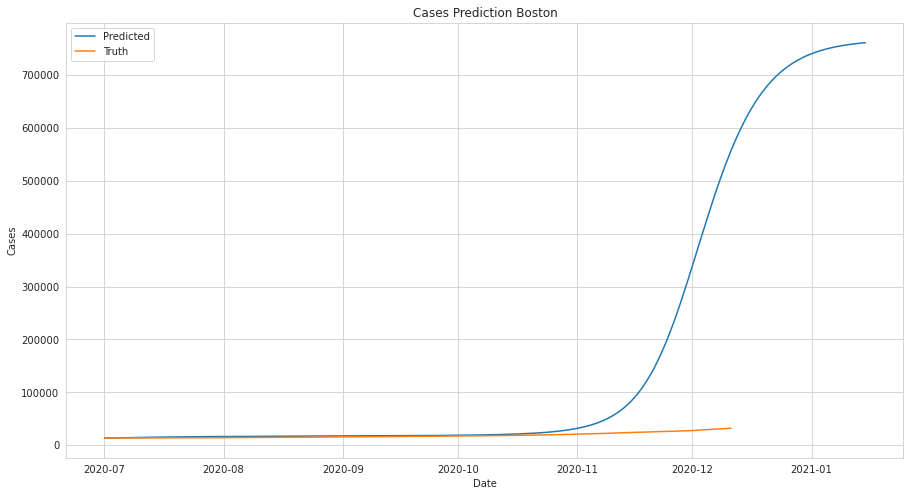

In [4]:
with sns.axes_style("whitegrid"):
    plt.figure(figsize=(15,8))
    sns.lineplot(data=pred_df, x='Day', y='Total Cases')
    sns.lineplot(data=truth_df, x='Date', y='total_cases')
    plt.ylabel('Cases')
    plt.xlabel('Date')
    plt.title('Cases Prediction Boston')
    plt.legend(['Predicted', 'Truth'])

## Combining Boston Data

In [33]:
boston_cases_old = pd.read_csv('processed/boston_cases_till_dec11.csv')
boston_cases_old.Date = pd.to_datetime(boston_cases_old.Date)

boston_cases = pd.read_excel("processed/boston_cases.xlsx")
boston_cases.Timestamp = pd.to_datetime(boston_cases.Timestamp, errors='coerce')

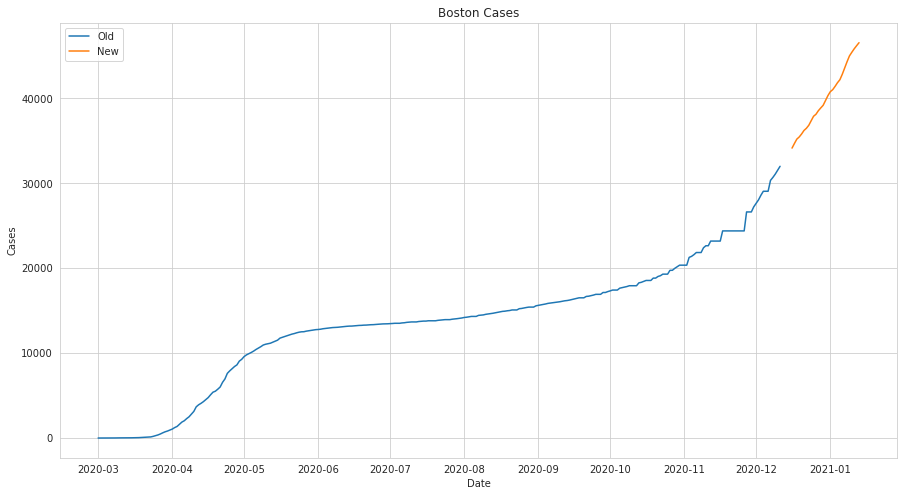

In [34]:
with sns.axes_style("whitegrid"):
    plt.figure(figsize=(15,8))
    sns.lineplot(data=boston_cases_old, x='Date', y='total_cases')
    sns.lineplot(data=boston_cases, x='Timestamp', y='Cases: Total Positive')
    plt.ylabel('Cases')
    plt.xlabel('Date')
    plt.title('Boston Cases')
    plt.legend(['Old', 'New'])

In [35]:
d1 = max(boston_cases_old.Date)
d2 = min(boston_cases.Timestamp)
n_days = (d2 - d1).days

missing_dates = [
    d1 + timedelta(days=i)
    for i in range(1, n_days)
]

C1 = max(boston_cases_old.total_cases)
C2 = min(boston_cases['Cases: Total Positive'])

avg_daily_inc = (C2 - C1) / (len(missing_dates)+1)
missing_cases = [ C1 + i*int(avg_daily_inc) for i in range(1, len(missing_dates)+1)]


all_dates = boston_cases_old.Date.to_list()
all_dates.extend(missing_dates)
all_dates.extend(boston_cases.Timestamp.to_list())

all_cases = boston_cases_old.total_cases.to_list()
all_cases.extend(missing_cases)
all_cases.extend(boston_cases['Cases: Total Positive'].to_list())

In [36]:
boston_cases_combined = pd.DataFrame({
    'Date': all_dates,
    'total_cases': all_cases
})

In [37]:
boston_cases_combined.to_csv('processed/boston_cases_combined.csv', index=False)

## Combining Cambridge and Boston Cases

In [38]:
cambridge_cases = pd.read_csv("processed/COVID-19_Case_Count_by_Date.csv")
cambridge_cases.Date = pd.to_datetime(cambridge_cases.Date)

In [39]:
start_date = min( min(boston_cases_combined.Date), min(cambridge_cases.Date) )
end_date = min( max(boston_cases_combined.Date), max(cambridge_cases.Date)  )

In [40]:
boston_cases_combined = boston_cases_combined.query('Date >= @start_date and Date <= @end_date')
cambridge_cases = cambridge_cases.query('Date >= @start_date and Date <= @end_date')

In [41]:
combined_cases = pd.DataFrame({
    'date': np.array(cambridge_cases.Date),
    'case_cnt': np.array(boston_cases_combined.total_cases) + np.array(cambridge_cases['Cumulative Confirmed Cases'])
})

In [43]:
combined_cases.to_csv('processed/cambridge_boston_combined.csv', index=False)

In [42]:
combined_cases.head()

,date,case_cnt
0,2020-03-01,0.0
1,2020-03-02,1.0
2,2020-03-03,1.0
3,2020-03-04,1.0
4,2020-03-05,5.0


## Final Model Results

In [49]:
pred_df = pd.read_csv('../predictions/predicted_cases_v3.csv')
pred_df.Day = pd.to_datetime(pred_df.Day)

In [52]:
start_date = pd.to_datetime("2020-07-01")
end_date = pd.to_datetime("2021-03-15")

truth_df = combined_cases.query('date >= @start_date and date <= @end_date')

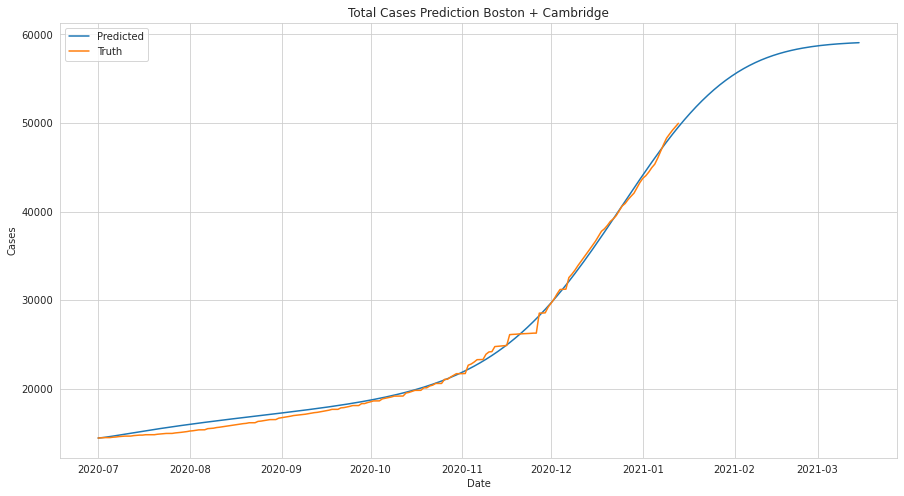

In [53]:
with sns.axes_style("whitegrid"):
    plt.figure(figsize=(15,8))
    sns.lineplot(data=pred_df, x='Day', y='Total Cases')
    sns.lineplot(data=truth_df, x='date', y='case_cnt')
    plt.ylabel('Cases')
    plt.xlabel('Date')
    plt.title('Total Cases Prediction Boston + Cambridge')
    plt.legend(['Predicted', 'Truth'])

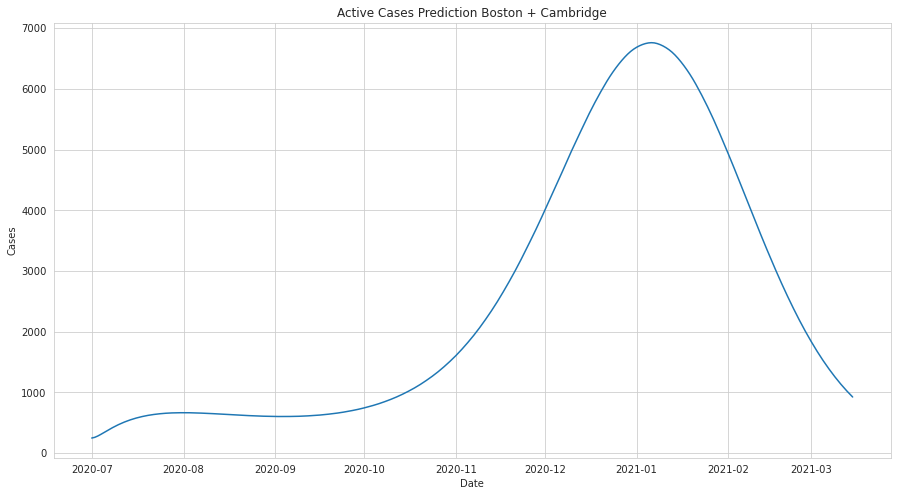

In [54]:
with sns.axes_style("whitegrid"):
    plt.figure(figsize=(15,8))
    sns.lineplot(data=pred_df, x='Day', y='Active Cases')
    plt.ylabel('Cases')
    plt.xlabel('Date')
    plt.title('Active Cases Prediction Boston + Cambridge')